In [ ]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8)

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from rdkit import Chem
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, auc
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor, MolSurf
from rdkit.Chem.Draw import rdMolDraw2D, MolToFile, _moltoimg
from AttentiveFP import Fingerprint, Fingerprint_viz
from AttentiveFP.getFeatures_aromaticity_rm import save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

/root/miniconda3/lib/python3.12/site-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


In [ ]:
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.display import SVG, display
import itertools
import random
import seaborn as sns; sns.set(color_codes=True)

In [3]:
task_name = 'aromaticity'
tasks = ['aromatic_count']

raw_filename = "../data/aromatic_atom_count.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.cano_smiles.values
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)


In [ ]:
random_seed = 8 
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 100
epochs = 800
p_dropout= 0.2
weight_decay = 5                 
learning_rate = 2.5             

fingerprint_dim = 200
radius = 2                       
T = 2                            
per_task_output_units_num = 1    
output_units_num = len(tasks) * per_task_output_units_num

(790, 2)
(3159, 2)


/tmp/ipykernel_2150/1209296229.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot([float(v) for v in train_df['aromatic_count']], bins=30, color="grey", label = "Train", kde=False, norm_hist=True)
/tmp/ipykernel_2150/1209296229.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot([fl

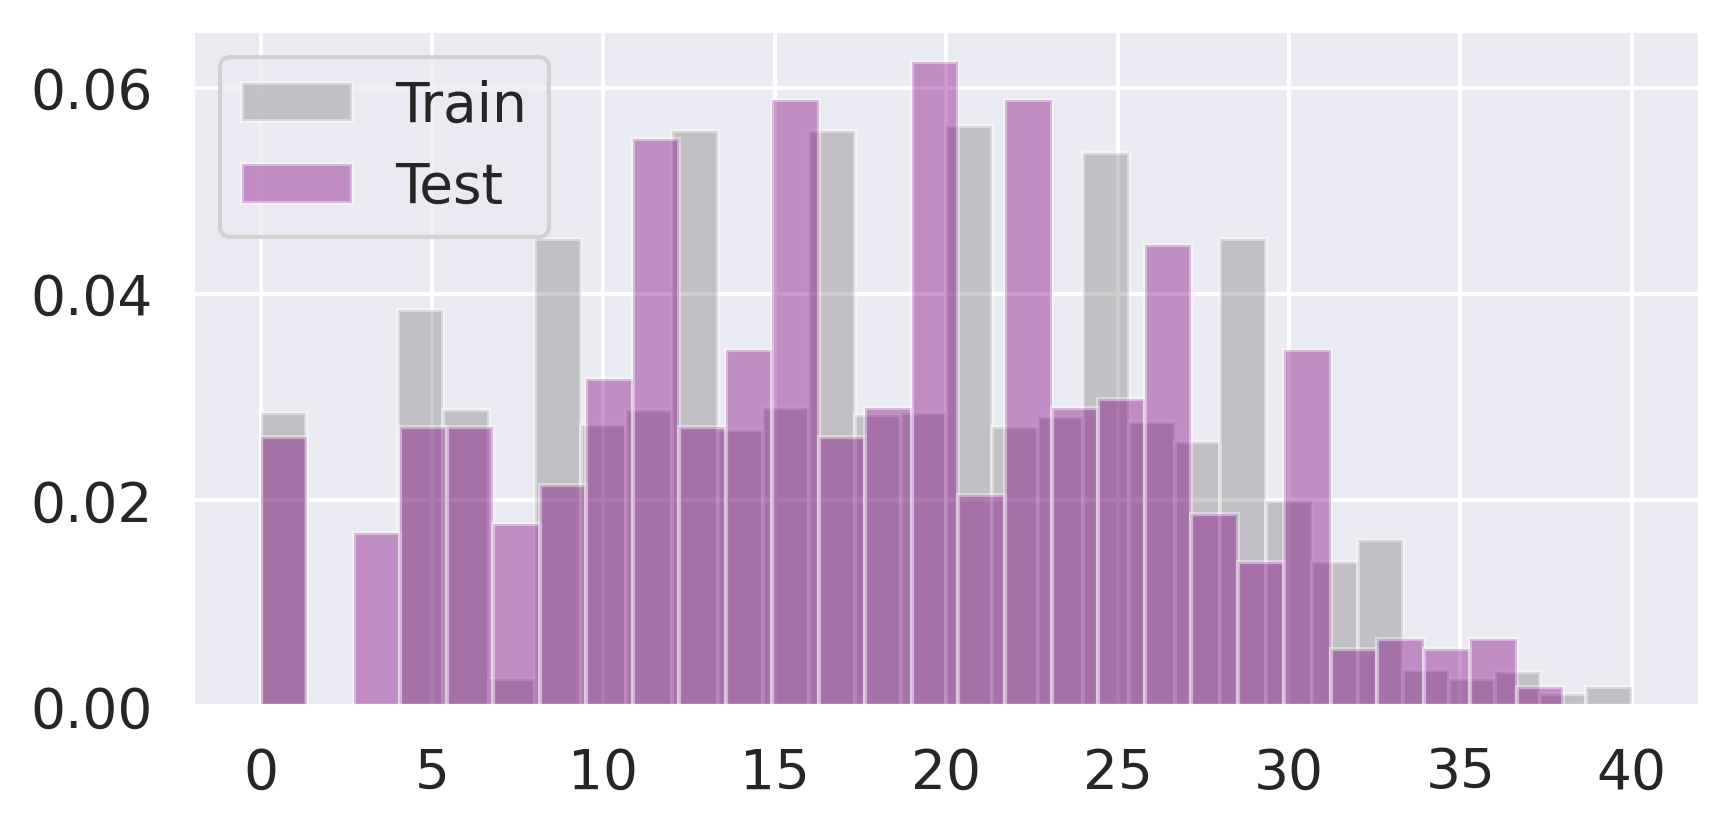

In [ ]:
test_df = smiles_tasks_df.sample(frac=1/5,random_state=random_seed)
train_df = smiles_tasks_df.drop(test_df.index)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(test_df.shape)
print(train_df.shape)
plt.figure(dpi=300,figsize=(6, 3))
sns.set(font_scale=1.2)
ax = sns.distplot([float(v) for v in train_df['aromatic_count']], bins=30, color="grey", label = "Train", kde=False, norm_hist=True)
ax1 = sns.distplot([float(v) for v in test_df['aromatic_count']], bins=28, color="purple", label = "Test", kde=False, norm_hist=True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
plt.close()

In [6]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

In [ ]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])

    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df.aromatic_count.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        model.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()
        
def eval(model, dataset):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    y_val_list = []
    y_pred_list = []
#     np.random.seed(8)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values

        y_val = batch_df.aromatic_count.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
        y_val_list.extend(y_val)
        y_pred_list.extend(np.array(mol_prediction.data.squeeze().cpu().numpy()))
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    r2 = r2_score(y_val_list,y_pred_list)
    return np.array(eval_MAE_list).mean(), np.array(eval_MSE_list).mean(),r2


In [ ]:
best_param ={}
best_param["train_epoch"] = 800
best_param["test_epoch"] = 200
best_param["train_MSE"] = 9e8
best_param["test_MSE"] = 9e8

for epoch in range(800):
    train_MAE, train_MSE, train_r2 = eval(model, train_df)
    test_MAE, test_MSE, test_r2 = eval(model, test_df)
    print(epoch, np.sqrt(train_MSE), np.sqrt(test_MSE), train_r2, test_r2)
    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE
    if test_MSE < best_param["test_MSE"]:
        best_param["test_epoch"] = epoch
        best_param["test_MSE"] = test_MSE
        if test_MSE < 0.5:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if (epoch - best_param["train_epoch"] >2) and (epoch - best_param["test_epoch"] >8):        
        break
    train(model, train_df, optimizer, loss_function)


/tmp/ipykernel_2150/3953271537.py:45: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))


0 19.496508 19.218397 -4.151844395456956 -4.167398146132306
1 3.4974227 3.4912603 0.8342149567278029 0.8294694920136594
2 2.0627148 2.0416057 0.9423329901899943 0.9416848510453526
3 1.5482111 1.5546298 0.9675130138155659 0.9661863806903432
4 1.4786834 1.4869002 0.9703653769908355 0.9690684765506538
5 1.4431849 1.4712226 0.9717711661290849 0.9697173085369952
6 1.4195398 1.4262172 0.9726885823266898 0.9715416971547332
7 1.451093 1.4599849 0.9714609534848664 0.9701781648654614
8 1.4015507 1.4210558 0.9733764092873959 0.9717473070226118
9 1.3670033 1.3973365 0.9746727429950558 0.9726825835867231
10 1.3843383 1.4241834 0.9740263219440931 0.9716228063727337
11 1.522307 1.5544635 0.9685910441883099 0.9661936166641015
12 1.3144331 1.3542669 0.9765832856002579 0.9743406189544568
13 1.3136529 1.3466036 0.9766110716971309 0.9746301891329344
14 1.4260976 1.4321699 0.9724356630488561 0.9713036452457066
15 1.4135147 1.4351515 0.9729199347245377 0.9711840386661461
16 1.2448643 1.2894198 0.97899643269

In [ ]:
# evaluate model

best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["test_epoch"])+'.pt') 
best_model = torch.load('saved_models/model_aromatic_atom_count_Wed_Apr_24_11-22-45_2019_19.pt')

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_MAE, test_MSE, test_r2 = eval(model, test_df)

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/model_aromatic_atom_count_Wed_Mar__5_01-10-51_2025_71.pt'

In [ ]:
# Feature visualization

model_for_viz = Fingerprint_viz(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model_for_viz.cuda()

model_for_viz.load_state_dict(best_model_wts)
(best_model.align[0].weight == model_for_viz.align[0].weight).all()


In [ ]:
def min_max_norm(dataset):
    if isinstance(dataset, list):
        norm_list = list()
        min_value = min(dataset)
        max_value = max(dataset)

        for value in dataset:
            tmp = (value - min_value) / (max_value - min_value)
            norm_list.append(tmp)
    return norm_list


In [ ]:
model_for_viz.eval()
test_MAE_list = []
test_MSE_list = []

out_feature_sorted = []
out_weight_sorted = []
mol_feature_sorted = []

dataset = test_df
test_MAE_list = []
test_MSE_list = []
valList = np.arange(0,dataset.shape[0])
batch_list = []
for i in range(0, dataset.shape[0], batch_size):
    batch = valList[i:i+batch_size]
    batch_list.append(batch) 
for counter, test_batch in enumerate(batch_list):
    batch_df = dataset.loc[test_batch,:]
    smiles_list = batch_df.cano_smiles.values
    y_val = batch_df[tasks[0]].values

    x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
    atom_feature_viz, atom_attention_weight_viz, mol_feature_viz, mol_feature_unbounded_viz, \
    mol_attention_weight_viz, mol_prediction = model_for_viz(
        torch.Tensor(x_atom), torch.Tensor(x_bonds),
        torch.cuda.LongTensor(x_atom_index),
        torch.cuda.LongTensor(x_bond_index),
        torch.Tensor(x_mask))

    mol_pred = np.array(mol_prediction.data.squeeze().cpu().numpy())
    atom_feature = np.stack([atom_feature_viz[L].cpu().detach().numpy() for L in range(radius+1)])
    atom_weight = np.stack([mol_attention_weight_viz[t].cpu().detach().numpy() for t in range(T)])
    mol_feature = np.stack([mol_feature_viz[t].cpu().detach().numpy() for t in range(T)])

    mol_feature_sorted.extend([mol_feature[:,i,:] for i in range(mol_feature.shape[1])])
    for i, smiles in enumerate(smiles_list):
        atom_num = i
        ind_mask = x_mask[i]
        ind_atom = smiles_to_rdkit_list[smiles]
        ind_feature = atom_feature[:, i]
        ind_weight = atom_weight[:, i]
        out_feature = []
        out_weight = []
        for j, one_or_zero in enumerate(list(ind_mask)):
            if one_or_zero == 1.0:
                out_feature.append(ind_feature[:,j])
                out_weight.append(ind_weight[:,j])
        out_feature_sorted.extend([out_feature[m] for m in np.argsort(ind_atom)])
        out_weight_sorted.extend([out_weight[m] for m in np.argsort(ind_atom)])        
        
        mol = Chem.MolFromSmiles(smiles)
        
        aromatic_boolean = [int(mol.GetAtomWithIdx(i).GetIsAromatic()) for i in range(mol.GetNumAtoms())]
        if len(aromatic_boolean)>30 and np.sum(aromatic_boolean)>3:
            weight_norm = min_max_norm([out_weight[m][0] for m in np.argsort(ind_atom)])

            print('aromatic atom count: '+str(np.sum(aromatic_boolean))+'\n'
                 'prediction: '+str(mol_pred[atom_num]))
            print(smiles)
            norm = matplotlib.colors.Normalize(vmin=0,vmax=1.28)
            cmap = cm.get_cmap('Oranges')
            plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
            atom_colors = {}
            weight_norm = np.array(weight_norm).flatten()
            threshold = weight_norm[np.argsort(weight_norm)[6]]
            weight_norm = np.where(weight_norm < threshold, 0, weight_norm)

            for i in range(len(ind_atom)):
                atom_colors[i] = plt_colors.to_rgba(float(weight_norm[i]))
            rdDepictor.Compute2DCoords(mol)

            drawer = rdMolDraw2D.MolDraw2DSVG(280,280)
            drawer.SetFontSize(1)
            op = drawer.drawOptions()

            mol = rdMolDraw2D.PrepareMolForDrawing(mol)
            drawer.DrawMolecule(mol,highlightAtoms=range(0,len(ind_atom)),highlightBonds=[],
                highlightAtomColors=atom_colors)
            drawer.FinishDrawing()
            svg = drawer.GetDrawingText()
            svg2 = svg.replace('svg:','')
            svg3 = SVG(svg2)
            display(svg3)

In [ ]:
raw_filename = "../data/aromatic_adversarial.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
adversarial_list = smiles_tasks_df.smiles.values
canonical_adversarial_list = []
for smiles in adversarial_list:
    canonical_adversarial_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
if os.path.isfile(feature_filename):
    feature_dicts_adversarial = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts_adversarial = save_smiles_dicts(canonical_adversarial_list,filename)


In [ ]:

x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = \
    get_smiles_array(canonical_adversarial_list,feature_dicts_adversarial)
atom_feature_viz, atom_attention_weight_viz, mol_feature_viz, mol_feature_unbounded_viz, \
mol_attention_weight_viz, mol_prediction = model_for_viz(
    torch.Tensor(x_atom), torch.Tensor(x_bonds),
    torch.cuda.LongTensor(x_atom_index),
    torch.cuda.LongTensor(x_bond_index),
    torch.Tensor(x_mask))

mol_pred = np.array(mol_prediction.data.squeeze().cpu().numpy())
atom_feature = np.stack([atom_feature_viz[L].cpu().detach().numpy() for L in range(radius+1)])
atom_weight = np.stack([mol_attention_weight_viz[t].cpu().detach().numpy() for t in range(T)])
mol_feature = np.stack([mol_feature_viz[t].cpu().detach().numpy() for t in range(T)])

mol_feature_sorted.extend([mol_feature[:,i,:] for i in range(mol_feature.shape[1])])
for i, smiles in enumerate(canonical_adversarial_list):
    atom_num = i
    ind_mask = x_mask[i]
    ind_atom = smiles_to_rdkit_list[smiles]
    ind_feature = atom_feature[:, i]
    ind_weight = atom_weight[:, i]
    out_feature = []
    out_weight = []
    for j, one_or_zero in enumerate(list(ind_mask)):
        if one_or_zero == 1.0:
            out_feature.append(ind_feature[:,j])
            out_weight.append(ind_weight[:,j])
    out_feature_sorted.extend([out_feature[m] for m in np.argsort(ind_atom)])
    out_weight_sorted.extend([out_weight[m] for m in np.argsort(ind_atom)])        

    mol = Chem.MolFromSmiles(smiles)

    aromatic_boolean = [int(mol.GetAtomWithIdx(i).GetIsAromatic()) for i in range(mol.GetNumAtoms())]
    
    weight_norm = min_max_norm([out_weight[m][0] for m in np.argsort(ind_atom)])

    print('aromatic atom count: '+str(np.sum(aromatic_boolean))+'\n'
         'prediction: '+str(mol_pred[atom_num]))
    print(smiles)
    norm = matplotlib.colors.Normalize(vmin=0,vmax=1.28)
    cmap = cm.get_cmap('Oranges')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {}
    weight_norm = np.array(weight_norm).flatten()
    threshold = weight_norm[np.argsort(weight_norm)[8]]
    weight_norm = np.where(weight_norm < threshold, 0, weight_norm)

    for i in range(len(ind_atom)):
        atom_colors[i] = plt_colors.to_rgba(float(weight_norm[i]))
    rdDepictor.Compute2DCoords(mol)

    drawer = rdMolDraw2D.MolDraw2DSVG(280,280)
    drawer.SetFontSize(1)
    op = drawer.drawOptions()

    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol,highlightAtoms=range(0,len(ind_atom)),highlightBonds=[],
        highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg2 = svg.replace('svg:','')
    svg3 = SVG(svg2)
    display(svg3)